In [145]:
import numpy as np
import pandas as pd
from collections import Counter


class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, depth = None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        self.depth = depth

    def is_leaf_node(self):
        return self.value is not None


class DecisionTreeClassifier:
    def __init__(self, max_depth=None, metric='gini'):
        self.max_depth = max_depth
        self.metric = metric

    def fit(self, X, y):
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X)
            self.feature_names = [f'Feature {i}' for i in range(X.shape[1])]
        else:
            self.feature_names = X.columns
        self.n_classes = len(set(y))
        self.n_features = X.shape[1]
        self.feature_names = X.columns
        self.root = self._grow_tree(X, y)

    def predict(self, X):
        if isinstance(X, np.ndarray):
                    X = pd.DataFrame(X, columns=self.feature_names)
        return np.array([self._predict(x) for _, x in X.iterrows()])

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        # Stopping conditions
        if (self.max_depth is not None and depth >= self.max_depth) or n_labels == 1 or n_samples < 2 or np.all(X == X.iloc[0].values):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feature, threshold = self._best_split(X, y)
        if feature is None:
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        mask = X.iloc[:, feature] <= threshold
        left = self._grow_tree(X[mask], y[mask], depth + 1)
        right = self._grow_tree(X[~mask], y[~mask], depth + 1)
        return Node(feature, threshold, left, right)

    def _best_split(self, X, y):
        best_split = None
        min_score = float('inf')
        for feature in range(self.n_features):
            x = X.iloc[:, feature]
            unique_values = np.unique(x)

            # If the feature is numeric, use midpoints; otherwise, use all unique values
            if np.issubdtype(x.dtype, np.number):
                sorted_values = np.sort(unique_values)
                thresholds = (sorted_values[:-1] + sorted_values[1:]) / 2
            else:
                thresholds = unique_values

            for threshold in thresholds:
                mask = x <= threshold
                left, right = y[mask], y[~mask]
                score = self._split_score(left, right)
                if score < min_score:
                    best_split = (feature, threshold)
                    min_score = score
        return best_split

    def _split_score(self, left, right):
        if self.metric == 'gini':
            score_func = self._gini
        elif self.metric == 'entropy':
            score_func = self._entropy
        else:
            raise ValueError("Invalid metric. Supported metrics are 'gini' and 'entropy'.")

        p_left = len(left) / (len(left) + len(right))
        p_right = len(right) / (len(left) + len(right))
        score = p_left * score_func(left) + p_right * score_func(right)
        return score

    def _gini(self, y):
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        return 1 - np.sum(np.square(probabilities))

    def _entropy(self, y):
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        return -np.sum(probabilities * np.log2(probabilities))

    def _most_common_label(self, y):
        return Counter(y).most_common(1)[0][0]

    def _predict(self, x):
        node = self.root
        while node.left:
            feature_name = self.feature_names[node.feature]
            if x[feature_name] <= node.threshold:
                node = node.left
            else:
                node = node.right
        return node.value
    


    def draw(self):
        from graphviz import Digraph
        def draw_node(node, parent=None, edge_label=None):
            nonlocal node_counter, dot
            if node.is_leaf_node():
                label = f'Leaf: {node.value}'
            else:
                feature_name = self.feature_names[node.feature]
                if isinstance(node.threshold, (int, float)):
                    threshold_str = f"{node.threshold:.2f}"
                else:
                    threshold_str = str(node.threshold)

                label = f'Feature {feature_name} <= {threshold_str}'
            
            node_id = f'node{node_counter}'
            dot.node(node_id, label)
            
            if parent is not None:
                dot.edge(parent, node_id, label=edge_label)
            
            node_counter += 1

            if not node.is_leaf_node():
                draw_node(node.left, node_id, 'True')
                draw_node(node.right, node_id, 'False')

        dot = Digraph()
        node_counter = 0
        draw_node(self.root)
        return dot

In [146]:
adult = pd.read_csv('data/adult.csv').sample(1000)
X = adult.drop('income', axis=1)
y = adult['income']

In [147]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [148]:
# Create and train the DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=5, metric='gini')
clf.fit(X_train, y_train)

In [149]:
# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.86
Classification Report:
              precision    recall  f1-score   support

       <=50K       0.91      0.92      0.91       239
        >50K       0.66      0.64      0.65        61

    accuracy                           0.86       300
   macro avg       0.78      0.78      0.78       300
weighted avg       0.86      0.86      0.86       300



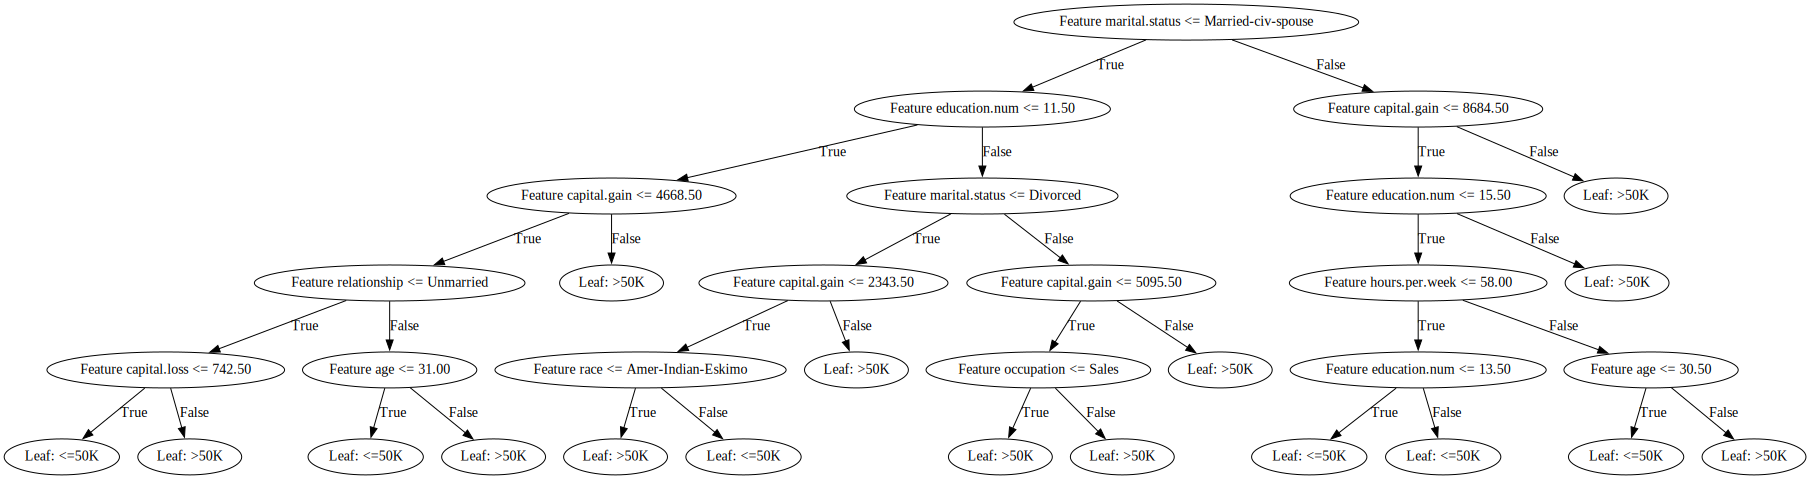

In [150]:
clf.draw()